# Clustering

---

## Overview
Oceanographers of many stripes think about the ocean in terms of watermasses. Water moves in masses with minimal mixing at the boundaries, maintaining core characteristics over long distances. Physical and chemical characteristics change in response to various processes, making it potentially helpful to label watermasses on the basis of multiple traits. In this notebook, we'll apply a handful of clustering algorithms readily available via [Scikit Learn](https://scikit-learn.org/stable/index.html) to a section and a surface. 

---

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import xarray as xr
import os
import pandas as pd
from pathlib import Path

import cftime

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil

from sklearn import cluster, datasets
from sklearn.metrics import euclidean_distances, silhouette_samples, silhouette_score
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler


In [2]:
import sys
module_path = str(Path(os.getcwd()).parent.parent/'support_functions') 
if module_path not in sys.path:
    sys.path.append(module_path)

import data_processing as dp
import plotting_helpers as ph 

In [4]:
lat_u = r'$^{\circ}$N'
lon_u = r'$^{\circ}$E'
depth_u = 'm'
time_u = 'ky BP'
eNd_label = r'$\varepsilon$Nd'

surface_title = 'depth={} '+depth_u+ ', time={} '+time_u

## Load Data

### C-iTRACE

In [5]:
import fsspec

url = 'https://g-f750ca.a78b8.36fe.data.globus.org/C-iTRACE/ctrace.decadal.SALT.zarr'
mapper = fsspec.get_mapper(url)
ds = xr.open_zarr(mapper)

variables = [
    'CISO_DIC_d13C','ND143','ND144',
]

for var in variables:
    url = 'https://g-f750ca.a78b8.36fe.data.globus.org/C-iTRACE/ctrace.decadal.{}.zarr'.format(var)
    mapper = fsspec.get_mapper(url)
    _ds = xr.open_zarr(mapper)
    ds = ds.merge(_ds)

ds

<xarray.Dataset>
Dimensions:        (time: 2200, z_t: 60, nlat: 116, nlon: 100, d2: 2)
Coordinates:
    TLAT           (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    TLONG          (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
  * time           (time) float64 -22.0 -21.99 -21.98 ... -0.03 -0.02 -0.01
  * z_t            (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    SALT           (time, z_t, nlat, nlon) float32 dask.array<chunksize=(275, 8, 15, 25), meta=np.ndarray>
    time_bound     (time, d2) float64 dask.array<chunksize=(2200, 2), meta=np.ndarray>
    CISO_DIC_d13C  (time, z_t, nlat, nlon) float32 dask.array<chunksize=(275, 8, 15, 25), meta=np.ndarray>
    ND143          (time, z_t, nlat, nlon) float32 dask.array<chunksize=(275, 8, 15, 25), meta=np.ndarray>
    ND144          (time, z_t, nlat, nlon) float32 dask.array<chunksize=(275, 8, 15, 25), meta=np.ndarray>
Attributes: (12/16)
    Conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    NCO:                        netCDF Operators version 4.9.5 (Homepage = ht...
    calendar:                   All years have exactly  365 days.
    cell_methods:               cell_methods = time: mean ==> the variable va...
    contents:                   Diagnostic and Prognostic Variables
    conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    ...                         ...
    revision:                    $Name: ccsm3_0_1_beta22 $
    source:                     POP, the NCAR/CSM Ocean Component
    start_time:                 This dataset was created on 2007-07-29 at 23:...
    tavg_sum:                   2592000.0
    tavg_sum_qflux:             2592000.0
    title:                      b30.22_0kaDVT

In [6]:
time_slice = slice(-8, -5)
iso_ds = ds.sel(dict(time=time_slice))

In [7]:
epsNd_tmp = xr.apply_ufunc(dp.epsNd, (iso_ds['ND143'],iso_ds['ND144']))
epsNd_tmp.name = 'eNd'
iso_ds['eNd'] = (('time', 'z_t', 'nlat', 'nlon'), epsNd_tmp.squeeze().data)
iso_ds = iso_ds.drop_vars(['ND143', 'ND144']).squeeze()

In [8]:
# convert depth from cm to m
iso_ds =dp.convert_z_to_meters(iso_ds)
iso_ds

<xarray.Dataset>
Dimensions:        (time: 301, z_t_m: 60, nlat: 116, nlon: 100, d2: 2)
Coordinates:
    TLAT           (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    TLONG          (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
  * time           (time) float64 -8.0 -7.99 -7.98 -7.97 ... -5.02 -5.01 -5.0
    z_t            (z_t_m) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_t_m          (z_t_m) float32 5.0 15.0 25.0 ... 5.125e+03 5.375e+03
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    SALT           (time, z_t_m, nlat, nlon) float32 dask.array<chunksize=(250, 8, 15, 25), meta=np.ndarray>
    time_bound     (time, d2) float64 dask.array<chunksize=(301, 2), meta=np.ndarray>
    CISO_DIC_d13C  (time, z_t_m, nlat, nlon) float32 dask.array<chunksize=(250, 8, 15, 25), meta=np.ndarray>
    eNd            (time, z_t_m, nlat, nlon) float32 dask.array<chunksize=(250, 8, 15, 25), meta=np.ndarray>
Attributes: (12/16)
    Conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    NCO:                        netCDF Operators version 4.9.5 (Homepage = ht...
    calendar:                   All years have exactly  365 days.
    cell_methods:               cell_methods = time: mean ==> the variable va...
    contents:                   Diagnostic and Prognostic Variables
    conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    ...                         ...
    revision:                    $Name: ccsm3_0_1_beta22 $
    source:                     POP, the NCAR/CSM Ocean Component
    start_time:                 This dataset was created on 2007-07-29 at 23:...
    tavg_sum:                   2592000.0
    tavg_sum_qflux:             2592000.0
    title:                      b30.22_0kaDVT

In [9]:
time = 5.99
iso_snapshot_data = iso_ds.sel(time = 5.99, method='nearest')
# iso_snapshot_data = iso_snapshot_data.compute()

## Clustering

The core of the matter is the function below. It takes in an array of tracer data (excluding positional coordinates like latitude, longitude, and depth!), and applies a handful of clustering algorithms. Some algorithms require that one specify the number of clusters in advance, while others require other parameters that describe other tolerances. For considerably more detail, check out the [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/clustering.html)! After assigning labels, we calculate a metric called the silohuette coefficient that describes the relationship between the tightness of each cluster relative to its separation from other clusters. A high silohuette coefficient indicates clusters are tight and well separated, while a lower value indicates the opposite.

Note! In this case, we are using these algorithms as classfication tools, not for predictive purposes. In another draft of this notebook it would certainly be worth setting this up as a modelling exercise in which we train the models on a subset of the data and test it on the remaining fraction. 

In [10]:


def test_clustering(data, lons, lats, N_CLUSTERS, cmap='Spectral'):
    pred_dict = {}
    np.random.seed(0)

    n_samples = 1500

    plot_num = 1
    for i_dataset, dataset in enumerate([data]):
        X = dataset
        # normalize dataset for easier parameter selection
        X = StandardScaler().fit_transform(X)

        # estimate bandwidth for mean shift
        bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

        # connectivity matrix for structured Ward
        connectivity = kneighbors_graph(X, n_neighbors=10)
        # make connectivity symmetric
        connectivity = 0.5 * (connectivity + connectivity.T)

        # Compute distances
        #distances = np.exp(-euclidean_distances(X))
        distances = euclidean_distances(X)

        # create clustering estimators
        ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
        two_means = cluster.MiniBatchKMeans(n_clusters=N_CLUSTERS)
        ward = cluster.AgglomerativeClustering(n_clusters=N_CLUSTERS,
                        linkage='ward', connectivity=connectivity)
        spectral = cluster.SpectralClustering(n_clusters=N_CLUSTERS,
                                              eigen_solver='arpack',
                                              affinity="nearest_neighbors")
        dbscan = cluster.DBSCAN(eps=.2)
        affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                           preference=-200)

        average_linkage = cluster.AgglomerativeClustering(linkage="average",
                                metric="cityblock", n_clusters=N_CLUSTERS,
                                connectivity=connectivity)

        for name, algorithm in [
                                ('MiniBatchKMeans', two_means),
                                ('AffinityPropagation', affinity_propagation),
                                # ('MeanShift', ms),
                                # ('SpectralClustering', spectral),
                                # ('Ward', ward),
                                # ('AgglomerativeClustering', average_linkage),
                                # ('DBSCAN', dbscan)
                               ]:
            # predict cluster memberships
            algorithm.fit(X)
            if hasattr(algorithm, 'labels_'):
                y_pred = algorithm.labels_.astype(np.int64)
            else:
                y_pred = algorithm.predict(X)
            
            sil_score = silhouette_score(X, y_pred, metric='euclidean')
            sample_sil_vals = silhouette_samples(X, y_pred)
            N_CLUSTERS = len(np.unique(y_pred.astype(float)))
            _colors_map = mpl.colormaps[cmap].resampled(N_CLUSTERS)
            _colors = _colors_map(np.linspace(0, 1, N_CLUSTERS))

            pred_dict[name] = [lons, lats, {'y_pred': y_pred, 'colors': _colors[y_pred].tolist(),
                                            'sample_sil_vals':sample_sil_vals,'sil_score':sil_score}  ]

    return pred_dict    


### Surface

#### Select a surface

In [11]:
lims = [290, 360]
lon_ds = dp.between(iso_snapshot_data, 'TLONG', lims)
lims = [-90, 90]
subarea_ds = dp.between(lon_ds, 'TLAT', lims)


In [12]:
depth = 500
surf_ds = subarea_ds.sel(z_t_m=depth, method='nearest')
surf_ds

<xarray.Dataset>
Dimensions:        (nlat: 116, nlon: 100, d2: 2)
Coordinates:
    TLAT           (nlat, nlon) float64 -79.5 -79.5 -79.5 ... 68.36 68.26 68.21
    TLONG          (nlat, nlon) float64 323.3 326.9 330.5 ... 317.8 319.3 320.8
    time           float64 -5.0
    z_t            float32 4.827e+04
    z_t_m          float32 482.7
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    SALT           (nlat, nlon) float32 dask.array<chunksize=(15, 25), meta=np.ndarray>
    time_bound     (d2, nlat, nlon) float64 dask.array<chunksize=(2, 116, 100), meta=np.ndarray>
    CISO_DIC_d13C  (nlat, nlon) float32 dask.array<chunksize=(15, 25), meta=np.ndarray>
    eNd            (nlat, nlon) float32 dask.array<chunksize=(15, 25), meta=np.ndarray>
Attributes: (12/16)
    Conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    NCO:                        netCDF Operators version 4.9.5 (Homepage = ht...
    calendar:                   All years have exactly  365 days.
    cell_methods:               cell_methods = time: mean ==> the variable va...
    contents:                   Diagnostic and Prognostic Variables
    conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    ...                         ...
    revision:                    $Name: ccsm3_0_1_beta22 $
    source:                     POP, the NCAR/CSM Ocean Component
    start_time:                 This dataset was created on 2007-07-29 at 23:...
    tavg_sum:                   2592000.0
    tavg_sum_qflux:             2592000.0
    title:                      b30.22_0kaDVT

In [13]:
lats = surf_ds.TLAT.data.ravel()
lons = surf_ds.TLONG.data.ravel()

proxy_vars=['CISO_DIC_d13C', 'SALT', 'eNd']
d = {var: surf_ds[var].data.ravel() for var in proxy_vars}
d['lat'] = lats
d['lon'] = lons

proxy_df_surf = pd.DataFrame(d)
proxy_df_surf = proxy_df_surf.dropna()

/Users/jlanders/opt/miniconda3/envs/paleobook-dev/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


#### Cluster

In [14]:
pred_dict_surf = test_clustering(proxy_df_surf[proxy_vars], proxy_df_surf['lon'], proxy_df_surf['lat'], 4)

/Users/jlanders/opt/miniconda3/envs/paleobook-dev/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#### Plot in positional coordinates

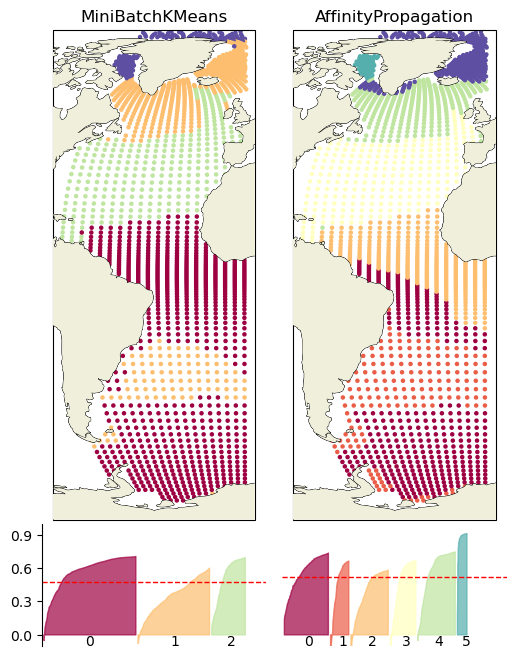

In [15]:

fig = plt.figure(figsize=(6, 8))
# 1 row, 2 columns, .05 space between columns, 8:.3 ratio of left column to right column
gs = gridspec.GridSpec(2, len(pred_dict_surf), wspace=0.07, hspace=.013,height_ratios=[8, 2])#, width_ratios=[8, .3])

for ik, key in enumerate(list(pred_dict_surf.keys())):
    # add subplot with specified map projection and coastlines (GeoAxes)
    ax2 = fig.add_subplot(gs[0, ik], projection=ccrs.Robinson(central_longitude=0))
    ax2.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)

    sample_silhouette_values = pred_dict_surf[key][2]['sample_sil_vals']
    y_pred = pred_dict_surf[key][2]['y_pred']
    colors = np.array(pred_dict_surf[key][2]['colors'])
    score = pred_dict_surf[key][2]['sil_score']
    
    ax2.scatter(proxy_df_surf['lon'],proxy_df_surf['lat'],c=colors, 
                transform=ccrs.PlateCarree(),  #map='tab20',
                 s=5)
    
    ax2.coastlines(linewidth=.5)
    ax2.add_feature(cfeature.LAND, zorder=14)
    ax2.set_title(key)
    
    N_CLUSTERS = len(np.unique(y_pred))-1
    ax2_sil = fig.add_subplot(gs[1, ik])#, projection=ccrs.Robinson(central_longitude=0))
    ax2_sil.set_ylim([-0.1, 1])
    ax2_sil.set_xlim([0, len(sample_silhouette_values)/2 + (N_CLUSTERS + 1) * 10])

    x_lower = 10
    
    for i in range(N_CLUSTERS):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[y_pred == i]

        color = colors[np.argwhere(y_pred == i)]

        ith_cluster_silhouette_values.sort()
        inds = np.arange(0, len(ith_cluster_silhouette_values), 2)
        ith_cluster_silhouette_values = ith_cluster_silhouette_values[inds]
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        if size_cluster_i>0:
            x_upper = x_lower + size_cluster_i
            ax2_sil.fill_between(np.linspace(x_lower, x_upper, len(ith_cluster_silhouette_values)),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax2_sil.text( x_lower + 0.45 * size_cluster_i,-0.1, str(i))#, size=axis_sz)

            # Compute the new y_lower for next plot
            x_lower = x_upper + 10  # 10 for the 0 samples

    # The vertical line for average silhoutte score of all the values
    ax2_sil.axhline(y=score, color="red", linestyle="--", linewidth=1)

    ax2_sil.set_xticks([])  # Clear the yaxis labels / ticks
    ax2_sil.set_yticks([ 0, .3, .6, .9])
    ax2_sil.spines['bottom'].set_visible(False)
    ax2_sil.grid(visible=False)
    ax2_sil.spines['right'].set_visible(False)
    ax2_sil.spines['top'].set_visible(False)

    if ik>0:
        ax2_sil.set_yticks([])
        ax2_sil.spines['left'].set_visible(False)



#### Plotting in cluster space
TSNE is a handy algorithm that allows us to collapse our multi-dimensional data down to two vectors that we can use as axes to plot our clusters. The code below fits and transforms the data using TSNE and then produces series of plots, each colored according to cluster labels. The values on the axes are not interperable, but rather give an interesting visual sense of how different algorithms assign labels.

In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=43)
Yt = tsne.fit_transform(proxy_df_surf[proxy_vars])
tsne_plot_df = pd.DataFrame({'TSNE_1':Yt[:,0], 'TSNE_2':Yt[:,1]})


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


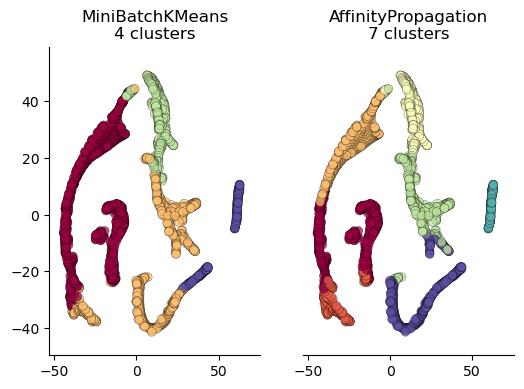

In [17]:
fig = plt.figure(figsize=(6, 4))
# 1 row, 2 columns, .05 space between columns, 8:.3 ratio of left column to right column
gs = gridspec.GridSpec(1, len(pred_dict_surf), wspace=0.2)#, width_ratios=[8, .3])
algs =list(pred_dict_surf.keys())

for ik, key in enumerate(algs):
    # add subplot with specified map projection and coastlines (GeoAxes)
    ax2 = fig.add_subplot(gs[0, ik])
    tsne_plot_df['clusters']= pred_dict_surf[key][2]['y_pred']#pred_dict_surf[key]#9
    
    num_clusters = len(tsne_plot_df['clusters'].unique())
    colors = np.array(pred_dict_surf[key][2]['colors'])
    ax2.scatter(tsne_plot_df['TSNE_1'], tsne_plot_df['TSNE_2'], c = colors,
                    edgecolor='black', s=40, alpha=.7, linewidth=.25)
    ax2.set_title('{}\n{} clusters'.format(key, num_clusters))
    ax2.set_xlim([tsne_plot_df['TSNE_1'].min()*1.2, tsne_plot_df['TSNE_1'].max()*1.2])
    ax2.set_ylim([tsne_plot_df['TSNE_2'].min()*1.2, tsne_plot_df['TSNE_2'].max()*1.2])
    ax2.legend().remove()
    ax2.grid(visible=False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    if ik >0:
        ax2.get_yaxis().set_visible(False)
        ax2.get_yaxis().set_ticks([])
        ax2.spines['left'].set_visible(False)
        


### Section clustering

#### Select the section of interest

In [18]:
lims = [340, 342]
sect_ds = dp.between(subarea_ds, 'TLONG', lims)

lat_lims = [min(sect_ds.TLAT.mean(dim='nlon')), max(sect_ds.TLAT.mean(dim='nlon'))]
lon_lims = np.mean(lims)*np.ones(2)

Now, we'll restructure it into a Pandas dataframe. 

In [19]:
lat_mesh, depth_mesh = np.meshgrid(sect_ds.TLAT.mean(dim='nlon'), sect_ds.z_t_m)

lats = lat_mesh.ravel()
depths = depth_mesh.ravel()

proxy_vars=['CISO_DIC_d13C', 'SALT', 'eNd']
d = {var: sect_ds[var].mean(dim='nlon').squeeze().data.ravel() for var in proxy_vars}
d['lat'] = lats
d['depth'] = depths

proxy_df_sect = pd.DataFrame(d)
proxy_df_sect = proxy_df_sect.dropna()

/Users/jlanders/opt/miniconda3/envs/paleobook-dev/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


#### Cluster

Just as before, we'll run it through the sausage maker.

In [20]:
pred_dict_sect = test_clustering(proxy_df_sect[proxy_vars], proxy_df_sect['depth'], proxy_df_sect['lat'], 4)

/Users/jlanders/opt/miniconda3/envs/paleobook-dev/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [21]:
cluster_output = [pd.DataFrame({'lat':pred_dict_sect[key][1], 
                                'depth':pred_dict_sect[key][0], 
                                key:pred_dict_sect[key][2]['y_pred']}).set_index(['lat', 'depth']) for ik, key in enumerate(list(pred_dict_sect.keys()))]


In [22]:
sect_cluster_df = cluster_output[0]
for df in cluster_output[1:]:
    sect_cluster_df = sect_cluster_df.merge(df, on=['lat', 'depth'])
    
sect_cluster_df = sect_cluster_df.merge(proxy_df_sect, on=['lat', 'depth'])
sect_cluster_df = sect_cluster_df.reset_index()

#### Plot in positional coordinates

This is the handy function from the ODV notebook that adds an inset map to the section plots.

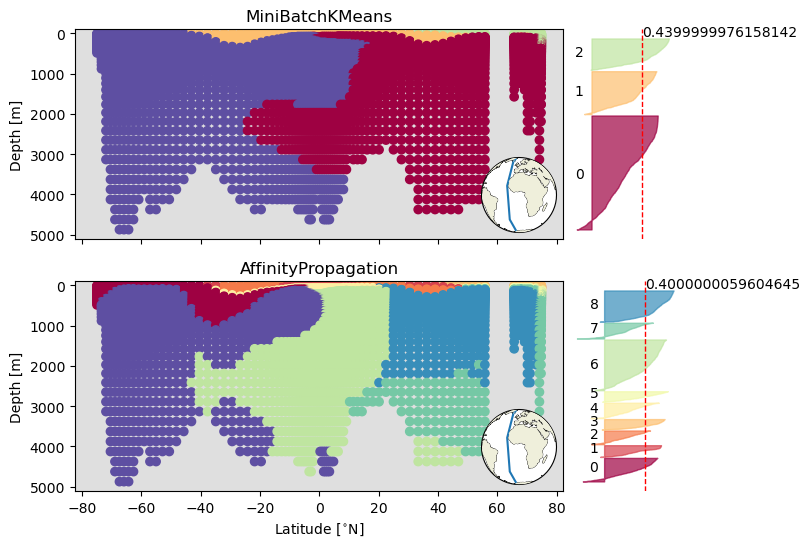

In [23]:

fig = plt.figure(figsize=(8, 3* len(pred_dict_sect)))
# 1 row, 2 columns, .05 space between columns, 8:.3 ratio of left column to right column
gs = gridspec.GridSpec(len(pred_dict_sect),2, hspace=0.2, wspace=.03,width_ratios=[8, 2])
algs =list(pred_dict_sect.keys())

for ik, key in enumerate(algs):
    
    sample_silhouette_values = pred_dict_sect[key][2]['sample_sil_vals']
    y_pred = pred_dict_sect[key][2]['y_pred']
    colors = np.array(pred_dict_sect[key][2]['colors'])
    score = pred_dict_sect[key][2]['sil_score']
    
    ax2 = fig.add_subplot(gs[ik, 0])#, projection=ccrs.Robinson(central_longitude=0))
    
    ax2.patch.set_facecolor('gray')
    ax2.patch.set_alpha(.25)
    
    ax2.scatter(proxy_df_sect['lat'],proxy_df_sect['depth'],
                         c=colors,
              )

    ylims = ax2.get_ylim()
    ax2.set_ylim([ylims[1], max([-100,ylims[0]])])
    ax2.set_ylabel('Depth [m]')
    ax2.set_xlabel('Latitude [{}]'.format(lat_u))

    ax2.set_title(key)
    if ik <len(algs)-1:
        # ax2.get_xaxis().set_visible(False)
        ax2.set_xlabel('')
        ax2.get_xaxis().set_ticklabels([])
        # ax2.spines['left'].set_visible(False)
    
    ph.make_inset_map(ax2, lat_lims, lon_lims, central_lon=0,central_lat=0, size_scaler=.15)
    
    N_CLUSTERS = len(np.unique(y_pred))-1
    ax2_sil = fig.add_subplot(gs[ik, 1])#, projection=ccrs.Robinson(central_longitude=0))
    
    y_lower = 10
    for i in range(N_CLUSTERS):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[y_pred == i]

        color = colors[np.argwhere(y_pred == i)]

        ith_cluster_silhouette_values.sort()
        inds = np.arange(0, len(ith_cluster_silhouette_values), 2)
        ith_cluster_silhouette_values = ith_cluster_silhouette_values[inds]
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        if size_cluster_i>0:
            
            y_upper = y_lower + size_cluster_i

            ax2_sil.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax2_sil.text(-0.15, y_lower + 0.45 * size_cluster_i, str(i))#, size=axis_sz)

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

    # The vertical line for average silhoutte score of all the values
    ax2_sil.axvline(x=score, color="red", linestyle="--", linewidth=1)
    ax2_sil.text(score, y_lower + 0.05 * size_cluster_i, '{}'.format(round(score,2)))

    ax2_sil.set_yticks([])  # Clear the yaxis labels / ticks
    ax2_sil.set_xticks([ 0, .3, .6, .9])
    ax2_sil.grid(visible=False)
    ax2_sil.spines['left'].set_visible(False)
    ax2_sil.spines['bottom'].set_visible(False)
    ax2_sil.spines['top'].set_visible(False)
    ax2_sil.spines['right'].set_visible(False)
    ax2_sil.set_xticks([])


---

## Summary
So many options for exploring our expectations about what are the core traits of a watermass, so little time!


## Resources and references

| _Citations_|
|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|Gu, Sifan, Liu, Zhengyu, Jahn, Alexandra, Zanowski, Hannah. (2021). C-iTRACE. Version 1.0. UCAR/NCAR - DASH Repository. https://doi.org/10.5065/hanq-bn92. 